### What gives concrete its strength

Sreekanth Reddy Sajjala


Concrete is the world's most widely used material. Its mainly composed of aggregates, fillers, water and cement, which is the main adhesive element. The variation in the quantity of these elements in concrete greatly effects its physical properties, carbon footprint and cost. For maximum strength, it would make sense to use a ratio where as much cement is used along with the appropriate amount of water used but this would make it economicaly unfeasible and very detrimental to the environment because of cement prodution's large carbon footprint. Aggregates help to fill volume after a certain strength is reached while fillers help reduce cost of the mixture while also contributing to the strength. In this report, we investigate how the compressive strength of the concrete changes with the quantities of these elements. We also look into the difference between coarse and fine aggeragates along with the effect of slag and fly ash as fillers.

The reason this is an interesting analysis is because by being able to predict the strength of conrete we will be able to optimize the amount of filler and aggregate used thereby saving a lot in costs. The relationship between the composition and the strength of the concreteis highly non linear due to the variety of chemical compounds present in cement and the physcial formation of alite and belite crystals within the concrete.



#### Importing the requried packages

In [70]:
import numpy as np
from jax import jit
import numpy.random as npr
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from tqdm import tqdm_notebook as tqdmn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import pandas as pd
#import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
import matplotlib
from matplotlib.pyplot import *
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Dataset

We are using UCI's concrete compressive strength data repository which has a 1030 instances. The data is very clean with no missing values. 


Variable Information:

Given is the variable name, variable type, the measurement unit and a brief description. 
The concrete compressive strength is the regression problem. The order of this listing 
corresponds to the order of numerals along the rows of the database. 

Name -- Data Type -- Measurement -- Description

All the components are quantitative and have the same units of kg in m3 mixture.
They are all input variables.

Cement (component 1)

Blast Furnace Slag (component 2)

Fly Ash (component 3) 

Water (component 4)

Superplasticizer (component 5) 

Coarse Aggregate (component 6) 

Fine Aggregate (component 7) 

Age is a quantitative variable which measures, in days, the time since the concrete was cast.

The output varible is the concrete's compressive strength. Its measured in mega pascals and is the only output variable.


In [71]:
df = pd.read_csv('/home/ssajjala/project3/Concrete_Data.csv')
def plot_with_error(category,title):
    age2=df[(df['Age']<10)]
    age3=df[(df['Age']>10) & (df['Age']<30)];
    age4=df[(df['Age']>30) & (df['Age']<100)];
    age5=df[(df['Age']>100) & (df['Age']<250)];
    age6=df[(df['Age']>250)];
    fig, ax = subplots()
    grouped6=age6.groupby(category)
    grouped2=age2.groupby(category)
    grouped3=age3.groupby(category)
    grouped4=age4.groupby(category)
    grouped5=age5.groupby(category)
    series2=grouped2['strength'].mean()
    series3=grouped3['strength'].mean()
    series4=grouped4['strength'].mean()
    series5=grouped5['strength'].mean()
    series6=grouped6['strength'].mean()
    err2=grouped2['strength'].sem()
    err3=grouped3['strength'].sem()
    err4=grouped4['strength'].sem()
    err5=grouped5['strength'].sem()
    err6=grouped6['strength'].sem()
    series2.plot(color='C2',yerr=err2)
    series3.plot(color='C3',yerr=err3)
    series4.plot(color='C4',yerr=err4)
    series5.plot(color='C5',yerr=err4)
    series6.plot(color='C6',yerr=err5)
    ax.legend(["20-30", "30-40", "40-50","50-60","60+"])
    plt.title(title)


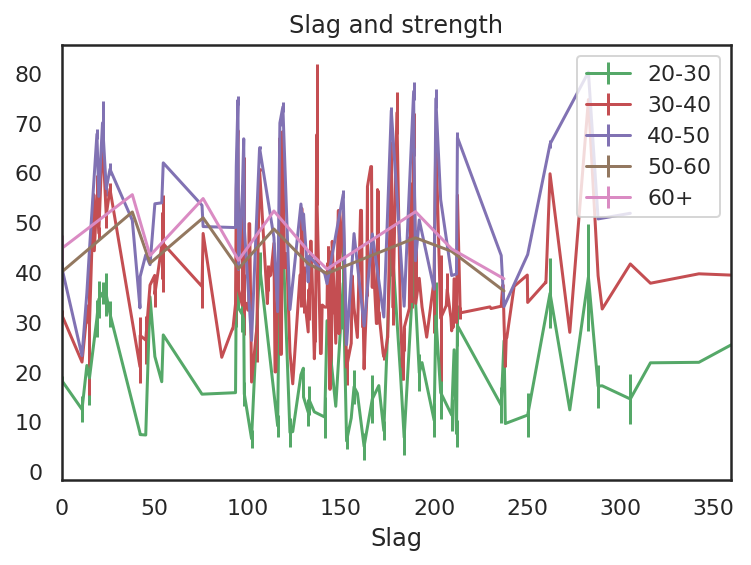

In [72]:
plot_with_error('Slag',"Slag and strength")

This plot seems like it does not contain any valuble information with all the noise and flat lines but it conveys something important about the dataset and concrete. It is not built as a test data set where different levels of slag are independently tested. Concrete is built to a specific strength and other variables are changed accordingly to achieve the same. The only variable which we can measure independently. is the Age of the pour as strength can be tested for the same mixture at different values of the variable.


In [73]:
df.head()

,Cement,Slag,Fly_Ash,Water,Superplasticizer,Coarse,Fine,Age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


 #### Splitting dataset into train and test data.

In [74]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
len(train)


835

In [75]:
list(df)

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age',
 'strength']

In [76]:
X_train = train.iloc[:, :8]
y_train = train.iloc[:, 8:]
x_test= test.iloc[:,8:]
y_test = test.iloc[:,8:]

In [77]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

# Calculate the mean squared error between 
#print(mse(y, y_est))
def mseloss(params, model, x, y):
    """
    :param flat_p: parameters to optimize
    :param unflattener: A function to unflatten the parameters into its original data structure.
    :param x: input data
    :param y: correct outputs
    """
    y_est = model(params, x)      # FITB
    return mse(y, y_est) 

from jax import grad

# `grad` as a function returns another function, let's call it `grad_func`.
# `grad_func`'s signature is identical to the original function passed into it.
# However, it's return statement returns an object of the same data structure
# as the first element passed into it, except now each element is a gradient scalar/tensor.
dmseloss = grad(mseloss)

### Basic linear regression

We shall first perfom basic linear regression to see how the strength of the cement shall vary with the various variables. This may not prove very useful as most of the relationships except for age are highly non linear

In [78]:

list(df)

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age',
 'strength']

We shall be using all the variables as we don't know yet which have the most influence. We shall use the square of Age as the link between age and the strength of cement is a standardized topic which is non-linear and most tests used to grade cement measure the strength at fixed number of days since casting.  

In [79]:
import statsmodels.formula.api as smf
df['Age2']=df['Age']**2
model = smf.ols('strength ~  Slag +Cement + Fly_Ash+Water+Superplasticizer + Coarse +Fine+Age+Age2', data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     328.4
Date:                Mon, 29 Apr 2019   Prob (F-statistic):          4.63e-294
Time:                        21:16:39   Log-Likelihood:                -3660.7
No. Observations:                1030   AIC:                             7341.
Df Residuals:                    1020   BIC:                             7391.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.7458     21.746     -0.172      0.863     -46.417      38.926
Slag                 0.0956      0.008     11.526      0.000       0.079       0.112
Cement               0.1136      0.007     16.359      0.000       0.100       0.127
Fly_Ash              0.0740      0.010      7.185      0.000       0.054       0.094
Water               -0.1739      0.033     -5.294      0.000      -0.238      -0.109
Superplasticizer     0.1993      0.076      2.607      0.009       0.049       0.349
Coarse               0.0082      0.008      1.064      0.287      -0.007       0.023
Fine                 0.0100      0.009      1.146      0.252      -0.007       0.027
Age                  0.3529      0.011     30.750      0.000       0.330       0.375
Age2                -0.0008   3.61e-05    -22.550      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       14.464   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.145
Skew:                           0.144   Prob(JB):                     4.22e-05
Kurtosis:                       3.621   Cond. No.                     1.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
df.Age.median()

28.0

No handles with labels found to put in legend.


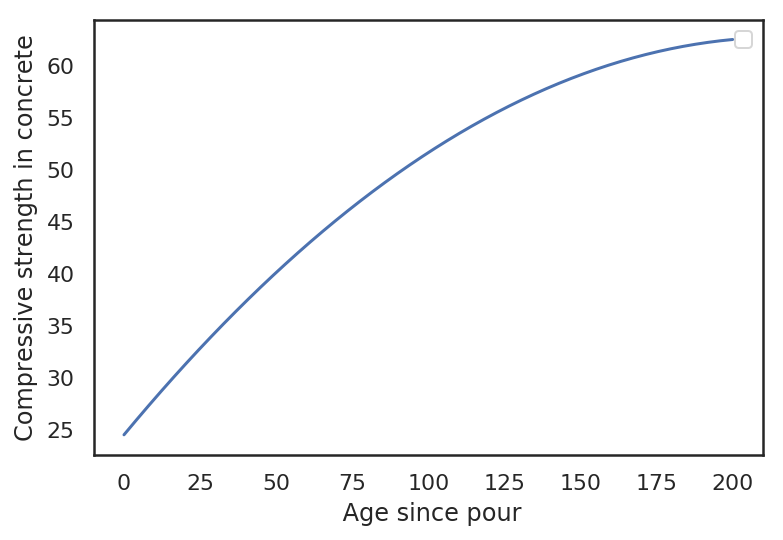

In [81]:

results = model.fit()
results.summary()
df2 = pd.DataFrame()
df2['Age'] = np.linspace(0, 200)
df2['Age2']=df2['Age']**2
df2['Fly_Ash']=55
df2['Water']=180
df2['Cement']=280

df2['Coarse'] = 970
df2['Fine']=780
df2['Superplasticizer']=6
df2['Slag']=70

results = model.fit()
pred12 = results.predict(df2)
plt.plot(df2['Age'], pred12)

plt.xlabel(' Age since pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();

We can clearly see the positive link between the strength of conrete and the number of days since its pour. Concrete reacts with the water to cure with time. We can see that the largest gain in strength is in the inital stages. The gain in strength then levels off but still continues to grow for years. Cement strength is usually measured by most standards at 28 days since casting


For some reason the model does not work when we try to change the explanatory variable from Age to anything else. I am unsure if I am ding something wrong with the code or if the model is unable to function.

No handles with labels found to put in legend.


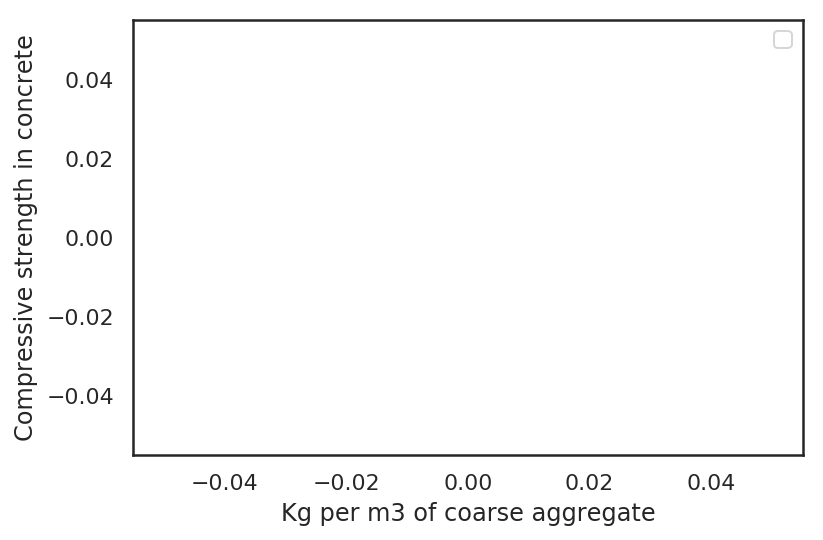

In [82]:
model = smf.ols('strength ~  Slag +Cement + Fly_Ash+Water+Superplasticizer + Coarse +Fine+Age', data=df)

df2 = pd.DataFrame()
df2['Age'] = 28
df2['Age2']=28**2
df2['Fly_Ash']=55
df2['Water']=180
df2['Cement']=280

df2['Coarse'] = np.linspace(0, 200)
df2['Fine']=780
df2['Superplasticizer']=6
df2['Slag']=70

results = model.fit()

results = model.fit()
results.summary()
pred13 = results.predict(df2)
plt.plot(df2['Coarse'], pred13)

plt.xlabel('Kg per m3 of coarse aggregate')
plt.ylabel('Compressive strength in concrete')
plt.legend();

Lets now try to run Lasso regression to undersatnd which variables effect the strength the most. 
I first satndardize the variables before dividing the dataset and running the regression.

In [83]:

xs_stand = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)
X = xs_stand.iloc[:, :8]
y = xs_stand.iloc[:, 8:]

Using the scipy function to create test and train sets.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [85]:
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [86]:


lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)
list(X_test)


['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age']

In [87]:
coef = lasso.coef_

In [88]:
names = X_train.columns

ValueError: x and y must have same first dimension, but have shapes (8,) and (2, 8)

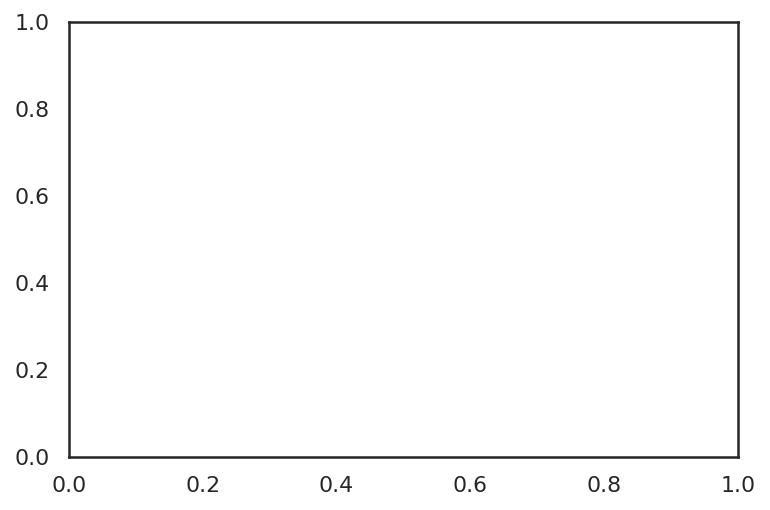

In [89]:


plt.plot(range(len(X_train.columns)), coef)
count = dict()
for i in range(len(coef)):
    if coef[i] > 0.02:
        count[i] = names[i]
    else:
        count[i] = ''

plt.xticks(range(len(count.keys())), count.values(), rotation=90)
plt.ylabel('Coefficients')
plt.show()



In [90]:
param_grid = {'alpha': np.arange(0.1,1,50)}

In [91]:
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X, y)
lasso_cv.best_params_

{'alpha': 0.1}

In [92]:
lasso_cv.best_score_

-2.027272529089009

In [93]:
from sklearn import linear_model

In [94]:
reg = linear_model.LinearRegression()

In [95]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [96]:

reg_pred = reg.predict(X_test)
reg.score(X_test, y_test)


0.9997070616217811

In [97]:
coef = reg.coef_
coef

array([[ 0.11346448,  0.07749585,  0.04239245, -0.17332687,  0.12385316,
         0.00571781,  0.01176529,  0.81083355],
       [-1.11346448, -1.07749585, -1.04239245, -0.82667313, -1.12385316,
        -1.00571781, -1.01176529, -1.81083355]])

In [98]:
names = X_train.columns

In [99]:
reg = linear_model.LinearRegression()
reg_cv = GridSearchCV(reg, param_grid, cv=5)


In [100]:
def standardize(self, df, label):
    """
    standardizes a series with name ``label'' within the pd.DataFrame
    ``df''.
    """
    df = df.copy(deep=True)
    series = df.loc[:, label]
    avg = series.mean()
    stdv = series.std()
    series_standardized = (series - avg)/ stdv
    return series_standardized

Now lets build a neural network and fit it our data. This seems useful to do as neural networks are great ways to explore non linear relationships between variables. 

Lets import all the required packages

In [101]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor

Now lets look at how the different variables correlated with each other. Its a nice visual which shall help us understand which variables have the most influence.

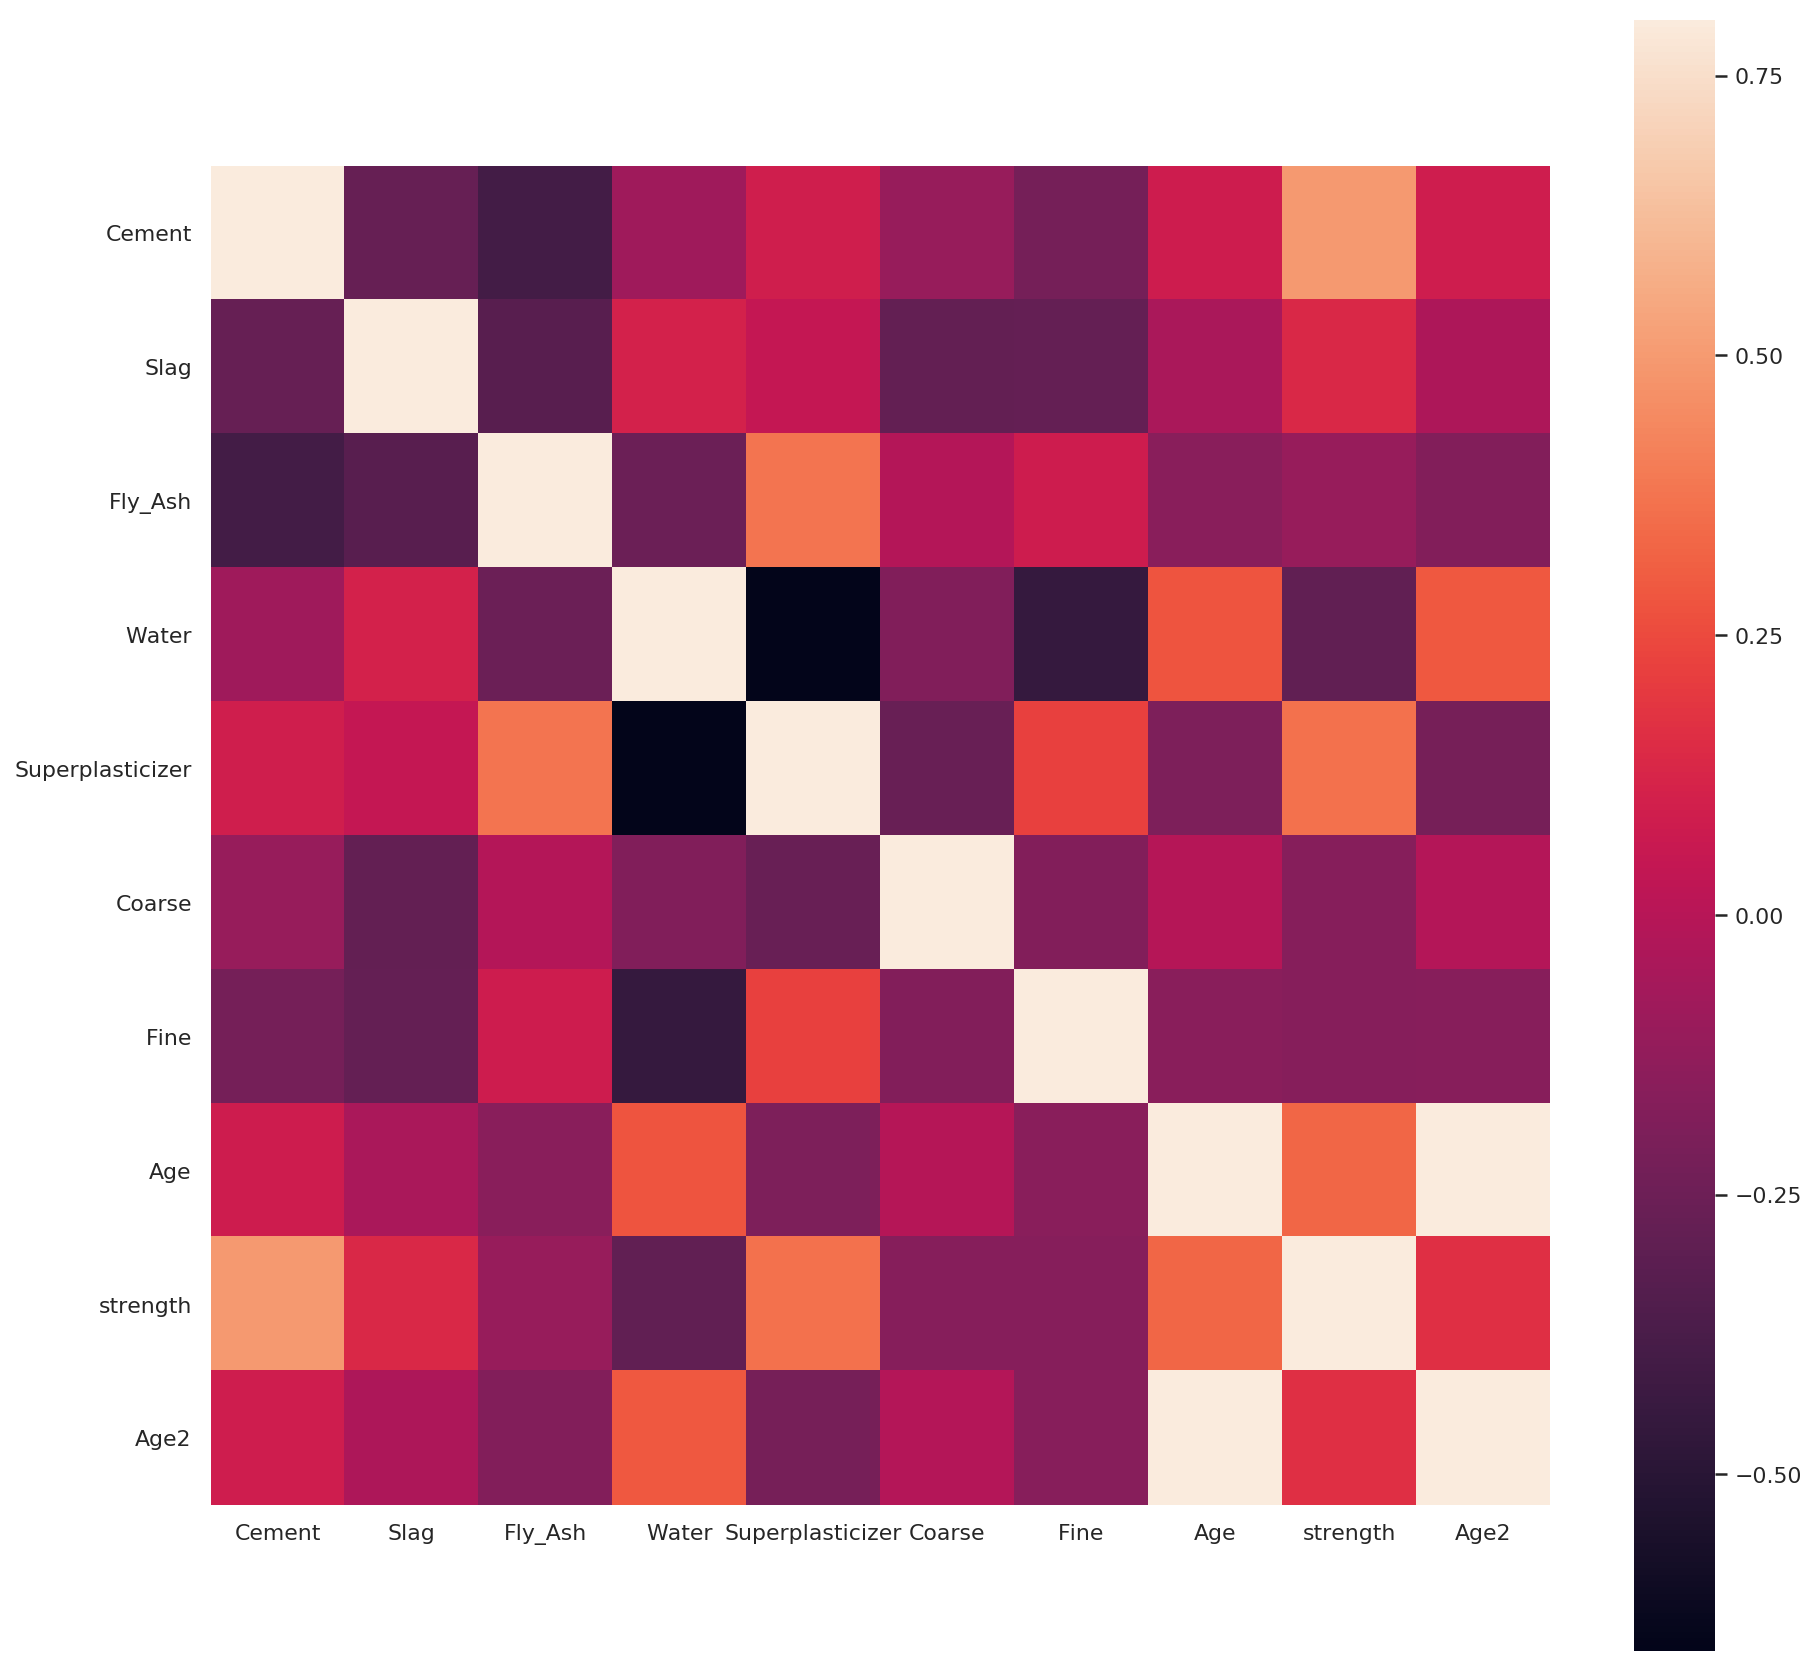

In [102]:
df.drop(columns=['Age2'])
C_mat = df.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

Lets build the Neural net. This is lifted from a template and is appropriate for a data set with < 20 numerical values and 1 numerical output.

In [103]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


Lets set some checkpoints for the neural net. We shall be monitoing the loss value. We shall only saving the weight values where we see a decrease in report. The target variable is being set to the strength of the cement.

In [104]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
train_data = train
target = train_data['strength'] 


Now lets fit the model to our data. We are running the thing for 2000 cycles.

In [ ]:
history= NN_model.fit(train, target, epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 668 samples, validate on 167 samples
Epoch 1/1000
668/668 [==============================] - 1s 1ms/step - loss: 18.7214 - mean_absolute_error: 18.7214 - val_loss: 10.1812 - val_mean_absolute_error: 10.1812

Epoch 00001: val_loss improved from inf to 10.18120, saving model to Weights-001--10.18120.hdf5
Epoch 2/1000
668/668 [==============================] - 0s 213us/step - loss: 12.4499 - mean_absolute_error: 12.4499 - val_loss: 6.6802 - val_mean_absolute_error: 6.6802

Epoch 00002: val_loss improved from 10.18120 to 6.68016, saving model to Weights-002--6.68016.hdf5
Epoch 3/1000
668/668 [==============================] - 0s 200us/step - loss: 9.3073 - mean_absolute_error: 9.3073 - val_loss: 9.4078 - val_mean_absolute_error: 9.4078

Epoch 00003: val_loss did not improve from 6.68016
Epoch 4/1000
668/668 [==============================] - 0s 211us/step - loss: 7.1241 - mean_absolute_error: 7.1241 - val_loss: 6.5813 - val_mean_absolute_error: 6.5813

Epoch 00004: val_loss improv

668/668 [==============================] - 0s 198us/step - loss: 1.3085 - mean_absolute_error: 1.3085 - val_loss: 0.9379 - val_mean_absolute_error: 0.9379

Epoch 00035: val_loss improved from 1.22421 to 0.93789, saving model to Weights-035--0.93789.hdf5
Epoch 36/1000
668/668 [==============================] - 0s 171us/step - loss: 1.1608 - mean_absolute_error: 1.1608 - val_loss: 1.2549 - val_mean_absolute_error: 1.2549

Epoch 00036: val_loss did not improve from 0.93789
Epoch 37/1000
668/668 [==============================] - 0s 172us/step - loss: 1.9333 - mean_absolute_error: 1.9333 - val_loss: 1.1669 - val_mean_absolute_error: 1.1669

Epoch 00037: val_loss did not improve from 0.93789
Epoch 38/1000
668/668 [==============================] - 0s 233us/step - loss: 2.5331 - mean_absolute_error: 2.5331 - val_loss: 1.7481 - val_mean_absolute_error: 1.7481

Epoch 00038: val_loss did not improve from 0.93789
Epoch 39/1000
668/668 [==============================] - 0s 259us/step - loss: 2.33


Epoch 00071: val_loss did not improve from 0.78769
Epoch 72/1000
668/668 [==============================] - 0s 178us/step - loss: 0.9175 - mean_absolute_error: 0.9175 - val_loss: 1.4851 - val_mean_absolute_error: 1.4851

Epoch 00072: val_loss did not improve from 0.78769
Epoch 73/1000
668/668 [==============================] - 0s 177us/step - loss: 1.5214 - mean_absolute_error: 1.5214 - val_loss: 1.1688 - val_mean_absolute_error: 1.1688

Epoch 00073: val_loss did not improve from 0.78769
Epoch 74/1000
668/668 [==============================] - 0s 177us/step - loss: 0.5533 - mean_absolute_error: 0.5533 - val_loss: 1.6054 - val_mean_absolute_error: 1.6054

Epoch 00074: val_loss did not improve from 0.78769
Epoch 75/1000
668/668 [==============================] - 0s 186us/step - loss: 2.2034 - mean_absolute_error: 2.2034 - val_loss: 2.8450 - val_mean_absolute_error: 2.8450

Epoch 00075: val_loss did not improve from 0.78769
Epoch 76/1000
668/668 [==============================] - 0s 162u


Epoch 00108: val_loss did not improve from 0.65105
Epoch 109/1000
668/668 [==============================] - 0s 200us/step - loss: 1.2573 - mean_absolute_error: 1.2573 - val_loss: 0.4947 - val_mean_absolute_error: 0.4947

Epoch 00109: val_loss improved from 0.65105 to 0.49474, saving model to Weights-109--0.49474.hdf5
Epoch 110/1000
668/668 [==============================] - 0s 155us/step - loss: 1.2044 - mean_absolute_error: 1.2044 - val_loss: 2.8847 - val_mean_absolute_error: 2.8847

Epoch 00110: val_loss did not improve from 0.49474
Epoch 111/1000
668/668 [==============================] - 0s 140us/step - loss: 1.5872 - mean_absolute_error: 1.5872 - val_loss: 1.1391 - val_mean_absolute_error: 1.1391

Epoch 00111: val_loss did not improve from 0.49474
Epoch 112/1000
668/668 [==============================] - 0s 183us/step - loss: 0.9578 - mean_absolute_error: 0.9578 - val_loss: 0.8115 - val_mean_absolute_error: 0.8115

Epoch 00112: val_loss did not improve from 0.49474
Epoch 113/100

668/668 [==============================] - 0s 163us/step - loss: 0.8455 - mean_absolute_error: 0.8455 - val_loss: 1.4622 - val_mean_absolute_error: 1.4622

Epoch 00145: val_loss did not improve from 0.41471
Epoch 146/1000
668/668 [==============================] - 0s 183us/step - loss: 1.5813 - mean_absolute_error: 1.5813 - val_loss: 3.1947 - val_mean_absolute_error: 3.1947

Epoch 00146: val_loss did not improve from 0.41471
Epoch 147/1000
668/668 [==============================] - 0s 190us/step - loss: 1.9778 - mean_absolute_error: 1.9778 - val_loss: 0.7855 - val_mean_absolute_error: 0.7855

Epoch 00147: val_loss did not improve from 0.41471
Epoch 148/1000
668/668 [==============================] - 0s 163us/step - loss: 1.0276 - mean_absolute_error: 1.0276 - val_loss: 0.5780 - val_mean_absolute_error: 0.5780

Epoch 00148: val_loss did not improve from 0.41471
Epoch 149/1000
668/668 [==============================] - 0s 119us/step - loss: 1.2064 - mean_absolute_error: 1.2064 - val_loss

668/668 [==============================] - 0s 197us/step - loss: 1.5272 - mean_absolute_error: 1.5272 - val_loss: 1.2167 - val_mean_absolute_error: 1.2167

Epoch 00182: val_loss did not improve from 0.41471
Epoch 183/1000
668/668 [==============================] - 0s 202us/step - loss: 0.7119 - mean_absolute_error: 0.7119 - val_loss: 0.5997 - val_mean_absolute_error: 0.5997

Epoch 00183: val_loss did not improve from 0.41471
Epoch 184/1000
668/668 [==============================] - 0s 229us/step - loss: 0.4271 - mean_absolute_error: 0.4271 - val_loss: 0.5008 - val_mean_absolute_error: 0.5008

Epoch 00184: val_loss did not improve from 0.41471
Epoch 185/1000
668/668 [==============================] - 0s 237us/step - loss: 0.8328 - mean_absolute_error: 0.8328 - val_loss: 0.4930 - val_mean_absolute_error: 0.4930

Epoch 00185: val_loss did not improve from 0.41471
Epoch 186/1000
668/668 [==============================] - 0s 205us/step - loss: 1.3096 - mean_absolute_error: 1.3096 - val_loss

668/668 [==============================] - 0s 280us/step - loss: 0.6729 - mean_absolute_error: 0.6729 - val_loss: 0.8426 - val_mean_absolute_error: 0.8426

Epoch 00219: val_loss did not improve from 0.41471
Epoch 220/1000
668/668 [==============================] - 0s 232us/step - loss: 0.7475 - mean_absolute_error: 0.7475 - val_loss: 0.5098 - val_mean_absolute_error: 0.5098

Epoch 00220: val_loss did not improve from 0.41471
Epoch 221/1000
668/668 [==============================] - 0s 219us/step - loss: 0.4148 - mean_absolute_error: 0.4148 - val_loss: 0.4822 - val_mean_absolute_error: 0.4822

Epoch 00221: val_loss did not improve from 0.41471
Epoch 222/1000
668/668 [==============================] - 0s 265us/step - loss: 1.0199 - mean_absolute_error: 1.0199 - val_loss: 0.4936 - val_mean_absolute_error: 0.4936

Epoch 00222: val_loss did not improve from 0.41471
Epoch 223/1000
668/668 [==============================] - 0s 239us/step - loss: 0.8169 - mean_absolute_error: 0.8169 - val_loss


Epoch 00255: val_loss did not improve from 0.40361
Epoch 256/1000
668/668 [==============================] - 0s 275us/step - loss: 1.3694 - mean_absolute_error: 1.3694 - val_loss: 2.3968 - val_mean_absolute_error: 2.3968

Epoch 00256: val_loss did not improve from 0.40361
Epoch 257/1000
668/668 [==============================] - 0s 305us/step - loss: 1.9906 - mean_absolute_error: 1.9906 - val_loss: 1.2923 - val_mean_absolute_error: 1.2923

Epoch 00257: val_loss did not improve from 0.40361
Epoch 258/1000
668/668 [==============================] - 0s 202us/step - loss: 0.8921 - mean_absolute_error: 0.8921 - val_loss: 1.0506 - val_mean_absolute_error: 1.0506

Epoch 00258: val_loss did not improve from 0.40361
Epoch 259/1000
668/668 [==============================] - 0s 247us/step - loss: 1.1177 - mean_absolute_error: 1.1177 - val_loss: 0.5782 - val_mean_absolute_error: 0.5782

Epoch 00259: val_loss did not improve from 0.40361
Epoch 260/1000
668/668 [==============================] - 0s

668/668 [==============================] - 0s 235us/step - loss: 1.1103 - mean_absolute_error: 1.1103 - val_loss: 1.5391 - val_mean_absolute_error: 1.5391

Epoch 00292: val_loss did not improve from 0.37123
Epoch 293/1000
668/668 [==============================] - 0s 215us/step - loss: 0.7016 - mean_absolute_error: 0.7016 - val_loss: 0.5811 - val_mean_absolute_error: 0.5811

Epoch 00293: val_loss did not improve from 0.37123
Epoch 294/1000
668/668 [==============================] - 0s 253us/step - loss: 0.9254 - mean_absolute_error: 0.9254 - val_loss: 1.0198 - val_mean_absolute_error: 1.0198

Epoch 00294: val_loss did not improve from 0.37123
Epoch 295/1000
668/668 [==============================] - 0s 271us/step - loss: 0.6327 - mean_absolute_error: 0.6327 - val_loss: 1.1170 - val_mean_absolute_error: 1.1170

Epoch 00295: val_loss did not improve from 0.37123
Epoch 296/1000
668/668 [==============================] - 0s 250us/step - loss: 0.7472 - mean_absolute_error: 0.7472 - val_loss


Epoch 00328: val_loss did not improve from 0.26801
Epoch 329/1000
668/668 [==============================] - 0s 245us/step - loss: 0.5071 - mean_absolute_error: 0.5071 - val_loss: 0.4880 - val_mean_absolute_error: 0.4880

Epoch 00329: val_loss did not improve from 0.26801
Epoch 330/1000
668/668 [==============================] - 0s 200us/step - loss: 0.5052 - mean_absolute_error: 0.5052 - val_loss: 0.7362 - val_mean_absolute_error: 0.7362

Epoch 00330: val_loss did not improve from 0.26801
Epoch 331/1000
668/668 [==============================] - 0s 234us/step - loss: 1.2431 - mean_absolute_error: 1.2431 - val_loss: 1.4331 - val_mean_absolute_error: 1.4331

Epoch 00331: val_loss did not improve from 0.26801
Epoch 332/1000
668/668 [==============================] - 0s 211us/step - loss: 1.2056 - mean_absolute_error: 1.2056 - val_loss: 1.4414 - val_mean_absolute_error: 1.4414

Epoch 00332: val_loss did not improve from 0.26801
Epoch 333/1000
668/668 [==============================] - 0s

668/668 [==============================] - 0s 352us/step - loss: 0.4415 - mean_absolute_error: 0.4415 - val_loss: 0.4920 - val_mean_absolute_error: 0.4920

Epoch 00365: val_loss did not improve from 0.21184
Epoch 366/1000
668/668 [==============================] - 0s 260us/step - loss: 0.9208 - mean_absolute_error: 0.9208 - val_loss: 0.6201 - val_mean_absolute_error: 0.6201

Epoch 00366: val_loss did not improve from 0.21184
Epoch 367/1000
668/668 [==============================] - 0s 277us/step - loss: 0.6811 - mean_absolute_error: 0.6811 - val_loss: 0.3951 - val_mean_absolute_error: 0.3951

Epoch 00367: val_loss did not improve from 0.21184
Epoch 368/1000
668/668 [==============================] - 0s 218us/step - loss: 0.5937 - mean_absolute_error: 0.5937 - val_loss: 0.8711 - val_mean_absolute_error: 0.8711

Epoch 00368: val_loss did not improve from 0.21184
Epoch 369/1000
668/668 [==============================] - 0s 214us/step - loss: 0.6435 - mean_absolute_error: 0.6435 - val_loss

668/668 [==============================] - 0s 321us/step - loss: 0.9674 - mean_absolute_error: 0.9674 - val_loss: 0.4844 - val_mean_absolute_error: 0.4844

Epoch 00402: val_loss did not improve from 0.21184
Epoch 403/1000
668/668 [==============================] - 0s 295us/step - loss: 0.9779 - mean_absolute_error: 0.9779 - val_loss: 0.5336 - val_mean_absolute_error: 0.5336

Epoch 00403: val_loss did not improve from 0.21184
Epoch 404/1000
668/668 [==============================] - 0s 311us/step - loss: 0.6143 - mean_absolute_error: 0.6143 - val_loss: 0.5268 - val_mean_absolute_error: 0.5268

Epoch 00404: val_loss did not improve from 0.21184
Epoch 405/1000
668/668 [==============================] - 0s 314us/step - loss: 0.6033 - mean_absolute_error: 0.6033 - val_loss: 0.2951 - val_mean_absolute_error: 0.2951

Epoch 00405: val_loss did not improve from 0.21184
Epoch 406/1000
668/668 [==============================] - 0s 338us/step - loss: 1.1238 - mean_absolute_error: 1.1238 - val_loss

668/668 [==============================] - 0s 440us/step - loss: 0.8285 - mean_absolute_error: 0.8285 - val_loss: 0.8039 - val_mean_absolute_error: 0.8039

Epoch 00439: val_loss did not improve from 0.21184
Epoch 440/1000
668/668 [==============================] - 0s 252us/step - loss: 0.5086 - mean_absolute_error: 0.5086 - val_loss: 0.8052 - val_mean_absolute_error: 0.8052

Epoch 00440: val_loss did not improve from 0.21184
Epoch 441/1000
668/668 [==============================] - 0s 222us/step - loss: 0.6084 - mean_absolute_error: 0.6084 - val_loss: 0.7602 - val_mean_absolute_error: 0.7602

Epoch 00441: val_loss did not improve from 0.21184
Epoch 442/1000
668/668 [==============================] - 0s 212us/step - loss: 0.6002 - mean_absolute_error: 0.6002 - val_loss: 0.4457 - val_mean_absolute_error: 0.4457

Epoch 00442: val_loss did not improve from 0.21184
Epoch 443/1000
668/668 [==============================] - 0s 229us/step - loss: 0.4685 - mean_absolute_error: 0.4685 - val_loss


Epoch 00475: val_loss did not improve from 0.20075
Epoch 476/1000
668/668 [==============================] - 0s 470us/step - loss: 0.5022 - mean_absolute_error: 0.5022 - val_loss: 1.2483 - val_mean_absolute_error: 1.2483

Epoch 00476: val_loss did not improve from 0.20075
Epoch 477/1000
668/668 [==============================] - 0s 352us/step - loss: 1.4808 - mean_absolute_error: 1.4808 - val_loss: 1.3790 - val_mean_absolute_error: 1.3790

Epoch 00477: val_loss did not improve from 0.20075
Epoch 478/1000
668/668 [==============================] - 0s 462us/step - loss: 0.8325 - mean_absolute_error: 0.8325 - val_loss: 0.3149 - val_mean_absolute_error: 0.3149

Epoch 00478: val_loss did not improve from 0.20075
Epoch 479/1000
668/668 [==============================] - 0s 350us/step - loss: 0.9424 - mean_absolute_error: 0.9424 - val_loss: 0.9711 - val_mean_absolute_error: 0.9711

Epoch 00479: val_loss did not improve from 0.20075
Epoch 480/1000
668/668 [==============================] - 0s


Epoch 00512: val_loss did not improve from 0.20075
Epoch 513/1000
668/668 [==============================] - 0s 429us/step - loss: 0.8545 - mean_absolute_error: 0.8545 - val_loss: 1.4053 - val_mean_absolute_error: 1.4053

Epoch 00513: val_loss did not improve from 0.20075
Epoch 514/1000
668/668 [==============================] - 0s 439us/step - loss: 1.5213 - mean_absolute_error: 1.5213 - val_loss: 1.2932 - val_mean_absolute_error: 1.2932

Epoch 00514: val_loss did not improve from 0.20075
Epoch 515/1000
668/668 [==============================] - 0s 510us/step - loss: 0.7331 - mean_absolute_error: 0.7331 - val_loss: 0.5166 - val_mean_absolute_error: 0.5166

Epoch 00515: val_loss did not improve from 0.20075
Epoch 516/1000
668/668 [==============================] - 0s 639us/step - loss: 0.2881 - mean_absolute_error: 0.2881 - val_loss: 0.9110 - val_mean_absolute_error: 0.9110

Epoch 00516: val_loss did not improve from 0.20075
Epoch 517/1000
668/668 [==============================] - 0s

668/668 [==============================] - 0s 514us/step - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.4291 - val_mean_absolute_error: 0.4291

Epoch 00549: val_loss did not improve from 0.17919
Epoch 550/1000
668/668 [==============================] - 0s 319us/step - loss: 0.7985 - mean_absolute_error: 0.7985 - val_loss: 0.3810 - val_mean_absolute_error: 0.3810

Epoch 00550: val_loss did not improve from 0.17919
Epoch 551/1000
668/668 [==============================] - 0s 275us/step - loss: 0.8251 - mean_absolute_error: 0.8251 - val_loss: 1.1917 - val_mean_absolute_error: 1.1917

Epoch 00551: val_loss did not improve from 0.17919
Epoch 552/1000
668/668 [==============================] - 0s 303us/step - loss: 0.6991 - mean_absolute_error: 0.6991 - val_loss: 0.8276 - val_mean_absolute_error: 0.8276

Epoch 00552: val_loss did not improve from 0.17919
Epoch 553/1000
668/668 [==============================] - 0s 289us/step - loss: 0.4353 - mean_absolute_error: 0.4353 - val_loss


Epoch 00585: val_loss did not improve from 0.17058
Epoch 586/1000
668/668 [==============================] - 0s 374us/step - loss: 1.0651 - mean_absolute_error: 1.0651 - val_loss: 1.3566 - val_mean_absolute_error: 1.3566

Epoch 00586: val_loss did not improve from 0.17058
Epoch 587/1000
668/668 [==============================] - 0s 303us/step - loss: 0.5615 - mean_absolute_error: 0.5615 - val_loss: 0.2797 - val_mean_absolute_error: 0.2797

Epoch 00587: val_loss did not improve from 0.17058
Epoch 588/1000
668/668 [==============================] - 0s 279us/step - loss: 0.5944 - mean_absolute_error: 0.5944 - val_loss: 0.2325 - val_mean_absolute_error: 0.2325

Epoch 00588: val_loss did not improve from 0.17058
Epoch 589/1000
668/668 [==============================] - 0s 339us/step - loss: 0.5850 - mean_absolute_error: 0.5850 - val_loss: 0.6342 - val_mean_absolute_error: 0.6342

Epoch 00589: val_loss did not improve from 0.17058
Epoch 590/1000
668/668 [==============================] - 0s


Epoch 00622: val_loss did not improve from 0.17058
Epoch 623/1000
668/668 [==============================] - 0s 385us/step - loss: 0.9570 - mean_absolute_error: 0.9570 - val_loss: 0.3462 - val_mean_absolute_error: 0.3462

Epoch 00623: val_loss did not improve from 0.17058
Epoch 624/1000
668/668 [==============================] - 0s 366us/step - loss: 0.8828 - mean_absolute_error: 0.8828 - val_loss: 0.4754 - val_mean_absolute_error: 0.4754

Epoch 00624: val_loss did not improve from 0.17058
Epoch 625/1000
668/668 [==============================] - 0s 451us/step - loss: 0.4283 - mean_absolute_error: 0.4283 - val_loss: 1.0117 - val_mean_absolute_error: 1.0117

Epoch 00625: val_loss did not improve from 0.17058
Epoch 626/1000
668/668 [==============================] - 0s 348us/step - loss: 0.4404 - mean_absolute_error: 0.4404 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634

Epoch 00626: val_loss improved from 0.17058 to 0.16344, saving model to Weights-626--0.16344.hdf5
Epoch 627/100

668/668 [==============================] - 0s 535us/step - loss: 0.4007 - mean_absolute_error: 0.4007 - val_loss: 0.5845 - val_mean_absolute_error: 0.5845

Epoch 00659: val_loss did not improve from 0.16344
Epoch 660/1000
668/668 [==============================] - 0s 565us/step - loss: 0.5183 - mean_absolute_error: 0.5183 - val_loss: 0.3491 - val_mean_absolute_error: 0.3491

Epoch 00660: val_loss did not improve from 0.16344
Epoch 661/1000
668/668 [==============================] - 0s 566us/step - loss: 0.4655 - mean_absolute_error: 0.4655 - val_loss: 1.8695 - val_mean_absolute_error: 1.8695

Epoch 00661: val_loss did not improve from 0.16344
Epoch 662/1000
668/668 [==============================] - 0s 512us/step - loss: 0.5527 - mean_absolute_error: 0.5527 - val_loss: 0.1674 - val_mean_absolute_error: 0.1674

Epoch 00662: val_loss did not improve from 0.16344
Epoch 663/1000
668/668 [==============================] - 0s 572us/step - loss: 0.6557 - mean_absolute_error: 0.6557 - val_loss

668/668 [==============================] - 0s 432us/step - loss: 0.3049 - mean_absolute_error: 0.3049 - val_loss: 0.1873 - val_mean_absolute_error: 0.1873

Epoch 00696: val_loss did not improve from 0.16344
Epoch 697/1000
668/668 [==============================] - 0s 388us/step - loss: 0.7874 - mean_absolute_error: 0.7874 - val_loss: 1.2119 - val_mean_absolute_error: 1.2119

Epoch 00697: val_loss did not improve from 0.16344
Epoch 698/1000
668/668 [==============================] - 0s 390us/step - loss: 0.8259 - mean_absolute_error: 0.8259 - val_loss: 1.3258 - val_mean_absolute_error: 1.3258

Epoch 00698: val_loss did not improve from 0.16344
Epoch 699/1000
668/668 [==============================] - 0s 383us/step - loss: 0.7395 - mean_absolute_error: 0.7395 - val_loss: 0.3737 - val_mean_absolute_error: 0.3737

Epoch 00699: val_loss did not improve from 0.16344
Epoch 700/1000
668/668 [==============================] - 0s 555us/step - loss: 0.6182 - mean_absolute_error: 0.6182 - val_loss


Epoch 00732: val_loss did not improve from 0.13093
Epoch 733/1000
668/668 [==============================] - 0s 378us/step - loss: 0.5668 - mean_absolute_error: 0.5668 - val_loss: 1.4935 - val_mean_absolute_error: 1.4935

Epoch 00733: val_loss did not improve from 0.13093
Epoch 734/1000
668/668 [==============================] - 0s 201us/step - loss: 1.3755 - mean_absolute_error: 1.3755 - val_loss: 0.5498 - val_mean_absolute_error: 0.5498

Epoch 00734: val_loss did not improve from 0.13093
Epoch 735/1000
668/668 [==============================] - 0s 219us/step - loss: 0.9414 - mean_absolute_error: 0.9414 - val_loss: 0.3231 - val_mean_absolute_error: 0.3231

Epoch 00735: val_loss did not improve from 0.13093
Epoch 736/1000
668/668 [==============================] - 0s 222us/step - loss: 0.5273 - mean_absolute_error: 0.5273 - val_loss: 0.5720 - val_mean_absolute_error: 0.5720

Epoch 00736: val_loss did not improve from 0.13093
Epoch 737/1000
668/668 [==============================] - 0s


Epoch 00769: val_loss did not improve from 0.13093
Epoch 770/1000
668/668 [==============================] - 0s 242us/step - loss: 0.5318 - mean_absolute_error: 0.5318 - val_loss: 0.6038 - val_mean_absolute_error: 0.6038

Epoch 00770: val_loss did not improve from 0.13093
Epoch 771/1000
668/668 [==============================] - 0s 309us/step - loss: 0.4721 - mean_absolute_error: 0.4721 - val_loss: 0.3069 - val_mean_absolute_error: 0.3069

Epoch 00771: val_loss did not improve from 0.13093
Epoch 772/1000
668/668 [==============================] - 0s 215us/step - loss: 0.3055 - mean_absolute_error: 0.3055 - val_loss: 0.6157 - val_mean_absolute_error: 0.6157

Epoch 00772: val_loss did not improve from 0.13093
Epoch 773/1000
668/668 [==============================] - 0s 301us/step - loss: 0.7018 - mean_absolute_error: 0.7018 - val_loss: 0.3195 - val_mean_absolute_error: 0.3195

Epoch 00773: val_loss did not improve from 0.13093
Epoch 774/1000
668/668 [==============================] - 0s


Epoch 00806: val_loss did not improve from 0.13093
Epoch 807/1000
668/668 [==============================] - 0s 708us/step - loss: 0.4270 - mean_absolute_error: 0.4270 - val_loss: 0.4007 - val_mean_absolute_error: 0.4007

Epoch 00807: val_loss did not improve from 0.13093
Epoch 808/1000
668/668 [==============================] - 0s 641us/step - loss: 0.6756 - mean_absolute_error: 0.6756 - val_loss: 0.2503 - val_mean_absolute_error: 0.2503

Epoch 00808: val_loss did not improve from 0.13093
Epoch 809/1000
668/668 [==============================] - 0s 440us/step - loss: 0.4182 - mean_absolute_error: 0.4182 - val_loss: 0.1909 - val_mean_absolute_error: 0.1909

Epoch 00809: val_loss did not improve from 0.13093
Epoch 810/1000
668/668 [==============================] - 0s 415us/step - loss: 0.4247 - mean_absolute_error: 0.4247 - val_loss: 0.4457 - val_mean_absolute_error: 0.4457

Epoch 00810: val_loss did not improve from 0.13093
Epoch 811/1000
668/668 [==============================] - 0s

668/668 [==============================] - 0s 409us/step - loss: 0.7756 - mean_absolute_error: 0.7756 - val_loss: 0.4732 - val_mean_absolute_error: 0.4732

Epoch 00843: val_loss did not improve from 0.09562
Epoch 844/1000
668/668 [==============================] - 0s 307us/step - loss: 0.4921 - mean_absolute_error: 0.4921 - val_loss: 0.2417 - val_mean_absolute_error: 0.2417

Epoch 00844: val_loss did not improve from 0.09562
Epoch 845/1000
668/668 [==============================] - 0s 410us/step - loss: 0.7195 - mean_absolute_error: 0.7195 - val_loss: 0.6020 - val_mean_absolute_error: 0.6020

Epoch 00845: val_loss did not improve from 0.09562
Epoch 846/1000
668/668 [==============================] - 0s 665us/step - loss: 0.5395 - mean_absolute_error: 0.5395 - val_loss: 0.9492 - val_mean_absolute_error: 0.9492

Epoch 00846: val_loss did not improve from 0.09562
Epoch 847/1000
668/668 [==============================] - 0s 464us/step - loss: 0.5056 - mean_absolute_error: 0.5056 - val_loss

668/668 [==============================] - 0s 535us/step - loss: 0.4511 - mean_absolute_error: 0.4511 - val_loss: 0.4812 - val_mean_absolute_error: 0.4812

Epoch 00880: val_loss did not improve from 0.09562
Epoch 881/1000
668/668 [==============================] - 0s 404us/step - loss: 0.3138 - mean_absolute_error: 0.3138 - val_loss: 0.3972 - val_mean_absolute_error: 0.3972

Epoch 00881: val_loss did not improve from 0.09562
Epoch 882/1000
668/668 [==============================] - 0s 573us/step - loss: 0.7210 - mean_absolute_error: 0.7210 - val_loss: 0.2838 - val_mean_absolute_error: 0.2838

Epoch 00882: val_loss did not improve from 0.09562
Epoch 883/1000
668/668 [==============================] - 0s 330us/step - loss: 0.8571 - mean_absolute_error: 0.8571 - val_loss: 0.7531 - val_mean_absolute_error: 0.7531

Epoch 00883: val_loss did not improve from 0.09562
Epoch 884/1000
668/668 [==============================] - 0s 369us/step - loss: 0.8520 - mean_absolute_error: 0.8520 - val_loss

Now lets choose the weights file which was last saved. This was last done when we saw an improvement in loss. 

In [63]:
wights_file = 'Weights-1831--0.06837.hdf5'

We shall now use those weights in our nueral net.

In [64]:
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Now lets make predictions from our test data using the fitted model.

In [65]:

predictions = NN_model.predict(test)


Now lets plot the changes in the loss as the training took place

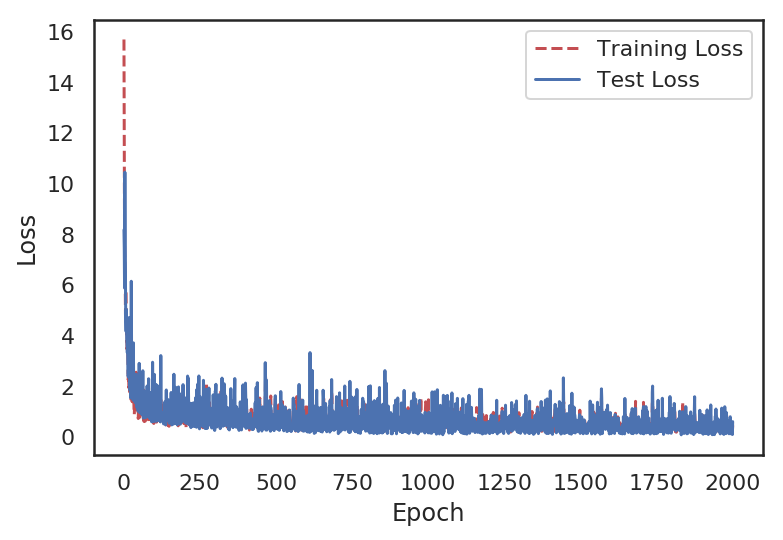

In [66]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Here we see that loss varys a lot but consistently kepps coming down

In [67]:
test.iat[0,8]-predictions[0]

array([0.30335617], dtype=float32)

In [68]:
i=0
avg=0
while i < len(predictions):
    mse=(test.iat[i,8]-predictions[i])**2
    #print(mse)
    avg=avg+mse
    i=i+1
print(avg/i)
print((avg/i)/df.strength.mean()*100)
print ("% of error. The avg error divided by the average strength")


[0.02364155]
[0.06600475]
% of error. The avg error divided by the average strength
